# item based collaborative filtering in KNN: MovieLens data 20M#

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
# import zipfile
# with zipfile.ZipFile("ml-latest.zip", 'r') as zip_ref:
#     zip_ref.extractall("./")

Firstly, we need to organize "ratings.csv": it is a file containing "user id", "movie id", "rating', "timestamp"

Data data frame (older version, it will be rating dataframe later):

In [ ]:
data = pd.read_csv('./track_traning.csv', header=1)
#data.columns = ["user id","item id" ,"rating", "timestamp"]
#data=data.drop(columns=['timestamp'])
print(data)
data.head#21627

      271200  0  2000  0.602    0.269  ...   95.687  4     26971.0  44.0  19
0     218347  0  1978  0.275  0.28800  ...  116.900  3     32237.0  51.0  21
1     163360  0  2018  0.701  0.86600  ...  128.001  4    136308.0  60.0  47
2     211427  0  1983  0.132  0.00558  ...   78.637  4    987193.0  66.0  30
3     278827  0  1978  0.559  0.60000  ...  128.402  4    313636.0  50.0  20
4     166907  0  1965  0.519  0.48100  ...  109.246  4     78100.0  52.0  59
...      ... ..   ...    ...      ...  ...      ... ..         ...   ...  ..
9994  121893  0  1979  0.243  0.85500  ...  156.241  3  33483326.0  89.0  29
9995  110107  0  1977  0.641  0.18500  ...  160.997  4     88541.0  68.0  43
9996  190134  0  1971  0.272  0.44000  ...  107.487  4         0.0  18.0  17
9997  107373  0  1966  0.630  0.04590  ...  115.351  3    135231.0  53.0  26
9998  248933  0  1976  0.577  0.61000  ...  207.143  4   4919372.0  80.0  43

[9999 rows x 18 columns]


<bound method NDFrame.head of       271200  0  2000  0.602    0.269  ...   95.687  4     26971.0  44.0  19
0     218347  0  1978  0.275  0.28800  ...  116.900  3     32237.0  51.0  21
1     163360  0  2018  0.701  0.86600  ...  128.001  4    136308.0  60.0  47
2     211427  0  1983  0.132  0.00558  ...   78.637  4    987193.0  66.0  30
3     278827  0  1978  0.559  0.60000  ...  128.402  4    313636.0  50.0  20
4     166907  0  1965  0.519  0.48100  ...  109.246  4     78100.0  52.0  59
...      ... ..   ...    ...      ...  ...      ... ..         ...   ...  ..
9994  121893  0  1979  0.243  0.85500  ...  156.241  3  33483326.0  89.0  29
9995  110107  0  1977  0.641  0.18500  ...  160.997  4     88541.0  68.0  43
9996  190134  0  1971  0.272  0.44000  ...  107.487  4         0.0  18.0  17
9997  107373  0  1966  0.630  0.04590  ...  115.351  3    135231.0  53.0  26
9998  248933  0  1976  0.577  0.61000  ...  207.143  4   4919372.0  80.0  43

[9999 rows x 18 columns]>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


There are *283228 users* in total in our dataset, *53889* movies in total.

In [ ]:
print(data['user id'].nunique())
print(data['item id'].nunique())


283228
53889


In [ ]:
import random
user=random.sample(data['user id'].unique().tolist(),round(283228*0.05))
len(user)

14161

Filter user data frame to only include users contained in random sample of 0.1% of original dataset, called "user":

In [ ]:
data=data[data['user id'].isin(user)]
data=data[data['item id']!=1]
print(data.shape)
data

(1385686, 3)


,user id,item id,rating
1493,17,32,3.0
1494,17,780,5.0
1587,19,3,4.0
1588,19,6,4.0
1589,19,9,4.0
...,...,...,...
27744168,283117,120799,5.0
27744169,283117,122882,3.0
27744170,283117,122900,5.0
27744171,283117,129354,4.0


Next, we capture tags information from tags.csv: each user commented on each movie using a word or a short phrase. The file contains "user id","movie id", "tag", "time stamp"

#Tags data frame:

In [ ]:
tags = pd.read_csv('./ml-latest/tags.csv', header=1)
tags.columns = ["user id","item id" ,"tag", "timestamp"]
tags=tags.drop(columns=['timestamp'])
tags=tags[tags['user id'].isin(user)]
print(tags.columns)
tags.head#21627

Index(['user id', 'item id', 'tag'], dtype='object')


<bound method NDFrame.head of          user id  item id            tag
16            42    37733  disappointing
17            42    37733      overrated
18            42    37733         stupid
386          332      236       Meg Ryan
387          332     3408  Julia Roberts
...          ...      ...            ...
1108436   282989     2571   martial arts
1108437   282989     2571          ulhas
1108438   282989     6365        awesome
1108672   283117     4011  Jason Statham
1108673   283117     4011   twist ending

[48289 rows x 3 columns]>

#movie dataframe:

In [ ]:
movies = pd.read_csv('./ml-latest/movies.csv', header=1)
movies.columns = ["movie id","title" ,"genres"]
print(movies.shape)
print(movies.columns)
movies.head(4)
#print(movies.head)
#movies.columns
# import re
# item_name="movie id | movie title | release date | video release date |IMDb URL | unknown | Action | Adventure |"+\
#             "Animation | Children's | Comedy | Crime | Documentary | Drama | Fantasy |"+\
#               "Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi |"+\
#               "Thriller | War | Western"
# item_column=[x.strip() for x in item_name.split("|")]
# item=[]
# item_file=open('./ml-100k/u.item',"r",encoding = "ISO-8859-1")
# for line in item_file:
#   new_line=re.split("\|+",line.rstrip())
#   date=re.search(r'\(([\d]+)\)',new_line[1])
#   if date is None:
#     date=""
#   else:
#     date=date.group(1)
#   new_line.insert(2,date)
#   name=re.search(r'(.+)\([\d]+\)',new_line[1])
#   if name is not None:
#     new_line[1]=name.group(1).strip()
#   #print(len(new_line))
#   item.append(new_line)
# item=pd.DataFrame(item,columns=item_column)
# item=item.drop(item.columns[[3,4]],axis=1)

(58097, 3)
Index(['movie id', 'title', 'genres'], dtype='object')


,movie id,title,genres
0,2,Jumanji (1995),Adventure|Children|Fantasy
1,3,Grumpier Old Men (1995),Comedy|Romance
2,4,Waiting to Exhale (1995),Comedy|Drama|Romance
3,5,Father of the Bride Part II (1995),Comedy





we can see there are no missing value in ratings, below is percentage of each rating by users: How each percentage distributed:


In [ ]:
hist=data['popularity'].value_counts(normalize=True) * 100
hist

KeyError: ignored

In [ ]:
list(data.columns.values)

KeyError: ignored

How many ratings are given to each movie?

In [ ]:
#We would like to obtain number of ratings per movie:
num_of_rating=data.groupby("item id")['rating'].count().tolist()
print(len(num_of_rating))
#data.groupby("item id")['rating'].count()
movie_id_sort=data.groupby("item id")['rating'].count().index
movie_id_sort

22383


Int64Index([     2,      3,      4,      5,      6,      7,      8,      9,
                10,     11,
            ...
            193201, 193203, 193209, 193443, 193465, 193473, 193523, 193649,
            193699, 193727],
           dtype='int64', name='item id', length=22383)

1) Use simple KNN to find clusters of similiar users:

Text(0, 0.5, 'num of ratings')

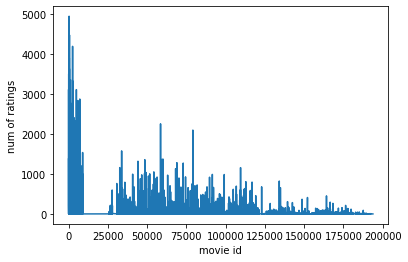

In [ ]:
import matplotlib.pyplot as plt
plt.plot(movie_id_sort,num_of_rating)
plt.xlabel('movie id')
plt.ylabel('num of ratings')

Now, we obtain a data frame with movie id as one column and its number of ratings as another column:

In [ ]:
data.groupby("item id")['rating'].count()

item id
2         1372
3          776
4          176
5          794
6         1404
          ... 
193473       1
193523       1
193649       1
193699       1
193727       1
Name: rating, Length: 22383, dtype: int64

Our ratings dataset contains too many movies and users, we can trim the size of dataset by filtering observations with movies which have been rated less than a threshold value, we define a function *remove_movie* to remove some rows,and return a new dataframe and number of movies left after trimming:

In [ ]:
data.groupby("item id")['rating'].count().max()

4939

In [ ]:
#threshold should less than 996!
def remove_movie(data,threshold):
    series=data.groupby("item id")['rating'].count()
    movieid=np.array(series[series<threshold].index).tolist()#movie id need to be deleted
    newdata=data[~data['item id'].isin(movieid)]
    return newdata, newdata['item id'].nunique(),movieid
rating,movie_size,movie_id_remove=remove_movie(data,50)
movie_size

3955

FIltering movies and tags DF:

In [ ]:
movies=movies[~movies['movie id'].isin(movie_id_remove)]
tags=tags[~tags['item id'].isin(movie_id_remove)]


In [ ]:
tags

,user id,item id,tag
16,42,37733,disappointing
17,42,37733,overrated
18,42,37733,stupid
386,332,236,Meg Ryan
387,332,3408,Julia Roberts
...,...,...,...
1108436,282989,2571,martial arts
1108437,282989,2571,ulhas
1108438,282989,6365,awesome
1108672,283117,4011,Jason Statham


Now we trim the size of our dataframe to include 8156 movies which has been rated by users at least 200 times!

---



In [ ]:
rating.groupby('item id')['user id']

#rating data frame:

In [ ]:
print(rating.shape)
print(rating['item id'].nunique())
rating.sort_values(by='item id')

(1250207, 3)
3955


,user id,item id,rating
9338781,96225,2,3.0
16432694,168057,2,4.0
5852589,60233,2,3.0
16454220,168236,2,3.0
5842735,60108,2,2.0
...,...,...,...
17780969,181785,187593,4.0
15116819,154497,187593,2.5
7878187,81037,187593,4.0
25956274,265010,187593,3.5


Create movie-user matrix:very sparse matrix, most entries are 0's

In [ ]:
movie_user_mat =rating.pivot(index='item id',columns='user id',values='rating').fillna(0)


In [ ]:
movie_user_mat

user id,17,19,33,42,51,52,124,162,179,182,188,215,294,303,332,336,346,371,391,397,416,420,443,446,526,571,595,613,630,635,648,651,670,684,724,753,757,772,778,779,...,282275,282316,282367,282378,282399,282419,282420,282435,282454,282469,282548,282587,282650,282667,282671,282679,282685,282695,282723,282726,282727,282780,282783,282853,282858,282862,282877,282886,282904,282926,282931,282944,282951,282955,282977,282989,283019,283060,283106,283117
item id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,2.5,0.0,3.5,0.0,0.0,0.0,0.0
3,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
6,0.0,4.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
179819,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
180031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


After filtering, how may movies and users left?
There are *3920* movies left, *14144* users left.

In [ ]:
print(movie_user_mat.shape)

(3955, 14143)


In [ ]:
from sklearn.neighbors import NearestNeighbors
model_knn = NearestNeighbors(metric='jaccard', algorithm='auto', n_neighbors=20, n_jobs=-1)

Hashmap is a dictionary with key as movie title, value as index from 0 to the length of movies. These movies are selected in rating data frame after filtering:

In [ ]:
# create mapper from movie title to index
hashmap={}
for i in movie_user_mat.index:
     movie=movies.set_index('movie id').loc[i].title
     hashmap[movie]=i

In [ ]:
pip install fuzzywuzzy

In [ ]:
from fuzzywuzzy import fuzz

/usr/local/lib/python3.6/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
def fuzzy_matching(hashmap, fav_movie):
        # """
        # return the closest match via fuzzy ratio.
        # If no match found, return None
        # Parameters
        # ----------
        # hashmap: dict, map movie title name to index of the movie in data
        # fav_movie: str, name of user input movie
        # Return
        # ------
        # index of the closest match
        # """
        match_tuple = []
        # get match
        for title, idx in hashmap.items():
            ratio = fuzz.ratio(title.lower(), fav_movie.lower())
            if ratio >= 60:
                match_tuple.append((title, idx, ratio))
        # sort
        match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
        if not match_tuple:
            print('Oops! No match is found')
        else:
            print('Found possible matches in our database: '
                  '{0}\n'.format([x[0] for x in match_tuple]))
            return match_tuple[0][1]

In [ ]:
import time

In [ ]:
#Test:
fuzzy_matching(hashmap, 'Jumanji (19950')

Found possible matches in our database: ['Jumanji (1995)', 'Junior (1994)', 'Darkman (1990)', 'Jade (1995)', 'Mermaids (1990)', 'Magnolia (1999)', 'Superman II (1980)', 'Mulan (1998)', 'Dead Man (1995)', 'Angus (1995)', 'Nixon (1995)', 'It (1990)', 'Tank Girl (1995)', 'My Family (1995)']



2

In [ ]:
reverse_hashmap = {v: k for k, v in hashmap.items()}

In [ ]:
def inference(model, data, hashmap,
                   fav_movie, n_recommendations):
        # """
        # return top n similar movie recommendations based on user's input movie
        # Parameters
        # ----------
        # model: sklearn model, knn model
        # data: movie-user matrix
        # hashmap: dict, map movie title name to index of the movie in data
        # fav_movie: str, name of user input movie
        # n_recommendations: int, top n recommendations
        # Return
        # ------
        # list of top n similar movie recommendations
        # """
        # fit
        model.fit(np.array(data))
        # get input movie index
        print('You have input movie:', fav_movie)
        idx = fuzzy_matching(hashmap, fav_movie)
        # inference
        print('Recommendation system start to make inference')
        print('......\n')
        t0 = time.time()
        distances, indices = model.kneighbors(
            np.array(data.loc[idx]).reshape(1,-1),
            n_neighbors=n_recommendations+1)
        indices=data.index[indices]
        # get list of raw idx of recommendations
        raw_recommends = \
            sorted(
                list(
                    zip(
                        indices.squeeze().tolist(),
                        distances.squeeze().tolist()
                    )
                ),
                key=lambda x: x[1]
            ,reverse=True)[:0:-1]
        print('It took my system {:.2f}s to make inference \n\
              '.format(time.time() - t0))
        # return recommendation (movieId, distance)
        return raw_recommends

In [ ]:
def make_recommendations(fav_movie,model,data, n_recommendations):
        # """
        # make top n movie recommendations
        # Parameters
        # ----------
        # fav_movie: str, name of user input movie
        # n_recommendations: int, top n recommendations
        # """
        # get recommendations
        raw_recommends = inference(
            model, data, hashmap,
            fav_movie, n_recommendations)
        # print results
        reverse_hashmap = {v: k for k, v in hashmap.items()}
        print('Recommendations for {}:'.format(fav_movie))
        for i,(idx, dist) in enumerate(raw_recommends):
            print('{0}: {1}, with distance '
                  'of {2}'.format(i+1,reverse_hashmap[idx], dist))

In [ ]:
#Test case 1:
make_recommendations('Tommy Boy (1995)',model_knn,movie_user_mat,10)

You have input movie: Tommy Boy (1995)
Found possible matches in our database: ['Tommy Boy (1995)', 'Tommy (1975)', 'Rob Roy (1995)', 'Toy Story 2 (1999)', 'Bad Boys (1995)', 'Sommersby (1993)', 'Tombstone (1993)', 'My Family (1995)', 'Toys (1992)', 'To Die For (1995)', 'Get Shorty (1995)', 'Commando (1985)', 'Only You (1994)', 'Miami Rhapsody (1995)', 'Mad Love (1995)', 'Smoke (1995)', 'Congo (1995)', 'Balto (1995)', 'My Bodyguard (1980)', 'Jerky Boys, The (1995)', 'Tom and Huck (1995)', 'Rio Bravo (1959)', 'Drugstore Cowboy (1989)', '8MM (1999)', 'Tom Jones (1963)', 'Cabin Boy (1994)', 'Jury Duty (1995)', 'Cat Ballou (1965)', 'Mummy, The (1999)', 'Dirty Work (1998)', 'Roman Holiday (1953)', 'Sgt. Bilko (1996)', 'Home Alone (1990)', 'Virtuosity (1995)', 'Milk Money (1994)', 'Party Girl (1995)', 'Two if by Sea (1996)', 'Mortal Kombat (1995)', 'Tremors (1990)', 'My Girl (1991)', 'Tampopo (1985)', 'Mumford (1999)', 'Stepmom (1998)', 'Rocky V (1990)', 'Orgazmo (1997)', 'Top Hat (1935)', '

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


In [ ]:
#Test case 2:
make_recommendations('Sense and Sensibility (1995)',model_knn,movie_user_mat,10)

You have input movie: Sense and Sensibility (1995)
Found possible matches in our database: ['Sense and Sensibility (1995)', 'Angels and Insects (1995)', 'Now and Then (1995)', 'Dead Presidents (1995)', 'Sudden Death (1995)']

Recommendation system start to make inference
......

It took my system 0.20s to make inference 
              
Recommendations for Sense and Sensibility (1995):
1: Sense and Sensibility (1995), with distance of 0.0
2: Leaving Las Vegas (1995), with distance of 0.7413185707096125
3: Four Weddings and a Funeral (1994), with distance of 0.7424583520936515
4: Dead Man Walking (1995), with distance of 0.7484817813765182
5: Birdcage, The (1996), with distance of 0.7596861206473762
6: Mr. Holland's Opus (1995), with distance of 0.7615894039735099
7: Truth About Cats & Dogs, The (1996), with distance of 0.7732018561484919
8: Piano, The (1993), with distance of 0.7773459189339256
9: Emma (1996), with distance of 0.7805049088359046
10: Sleepless in Seattle (1993), with dis

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


#2) Auto-encoder:#

In [ ]:
# Importing tensorflow
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
# Importing some more libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

In [ ]:
ratings_pivot=rating.pivot(index='user id',columns='item id',values='rating').fillna(0)

In [ ]:
# creating train and test sets
X_train, X_test = train_test_split(ratings_pivot, train_size=0.8)
X_train, X_val = train_test_split(X_train, train_size=0.8)


In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(9049, 4059)
(2263, 4059)
(2828, 4059)


In [ ]:
# Deciding how many nodes each layer should have
n_nodes_inpl = X_train.shape[1]
n_nodes_hl1  = 256
n_nodes_outl = X_train.shape[1]
# first hidden layer has 784*32 weights and 32 biases
hidden_1_layer_vals = {'weights':tf.Variable(tf.random_normal([n_nodes_inpl+1,n_nodes_hl1]))}
# first hidden layer has 784*32 weights and 32 biases
output_layer_vals = {'weights':tf.Variable(tf.random_normal([n_nodes_hl1+1,n_nodes_outl])) }

In [ ]:
# user with 3706 ratings goes in
input_layer = tf.placeholder('float', [None, X_train.shape[1]])
# add a constant node to the first layer
# it needs to have the same shape as the input layer for me to be
# able to concatinate it later
input_layer_const = tf.fill( [tf.shape(input_layer)[0], 1] ,1.0  )
input_layer_concat =  tf.concat([input_layer, input_layer_const], 1)
# multiply output of input_layer wth a weight matrix
layer_1 = tf.nn.sigmoid(tf.matmul(input_layer_concat,\
hidden_1_layer_vals['weights']))
# adding one bias node to the hidden layer
layer1_const = tf.fill( [tf.shape(layer_1)[0], 1] ,1.0  )
layer_concat =  tf.concat([layer_1, layer1_const], 1)
# multiply output of hidden with a weight matrix to get final output
output_layer = tf.matmul( layer_concat,output_layer_vals['weights'])
# output_true shall have the original shape for error calculations
output_true = tf.placeholder('float', [None, X_train.shape[1]])
# define our cost function
meansq =    tf.reduce_mean(tf.square(output_layer - output_true))
# define our optimizer
learn_rate = 0.1   # how fast the model should learn
optimizer = tf.train.AdagradOptimizer(learn_rate).minimize(meansq)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
# initialising variables and starting the session
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
# defining batch size, number of epochs and learning rate
batch_size = 100  # how many images to use together for training
hm_epochs =400    # how many times to go through the entire dataset
tot_users = X_train.shape[0] # total number of users

In [ ]:
# running the model for a 200 epochs taking 100 users in batches
# total improvement is printed out after each epoch
MSE_train=[]
MSE_val=[]
for epoch in range(hm_epochs):
    epoch_loss = 0    # initializing error as 0

    for i in range(int(tot_users/batch_size)):
        epoch_x = X_train[ i*batch_size : (i+1)*batch_size ]
        _, c = sess.run([optimizer, meansq],\
               feed_dict={input_layer: epoch_x, \
               output_true: epoch_x})
        epoch_loss += c

    output_train = sess.run(output_layer,\
               feed_dict={input_layer:X_train})
    output_test = sess.run(output_layer,\
                   feed_dict={input_layer:X_test})
    MSE_train.append(MSE(output_train, X_train))
    MSE_val.append(MSE(output_test, X_test))

    print('MSE train', MSE(output_train, X_train),'MSE test', MSE(output_test, X_test))
    print('Epoch', epoch, '/', hm_epochs, 'loss:',epoch_loss)

MSE train 57.48598447717692 MSE test 57.675476586004756
Epoch 0 / 400 loss: 7032.75662612915
MSE train 43.59329427578469 MSE test 43.691861198751276
Epoch 1 / 400 loss: 4489.733005523682
MSE train 35.46791325129852 MSE test 35.55757948912769
Epoch 2 / 400 loss: 3548.1943893432617
MSE train 29.9598050379521 MSE test 30.114151473657298
Epoch 3 / 400 loss: 2941.6142539978027
MSE train 26.32395293099139 MSE test 26.492072871761852
Epoch 4 / 400 loss: 2534.2001991271973
MSE train 23.70049628419113 MSE test 23.918680755177284
Epoch 5 / 400 loss: 2256.2596397399902
MSE train 21.805843913101803 MSE test 22.07401115529058
Epoch 6 / 400 loss: 2053.9328689575195
MSE train 20.3246911265242 MSE test 20.637284682667968
Epoch 7 / 400 loss: 1902.3302822113037
MSE train 19.111178324180962 MSE test 19.468428197107684
Epoch 8 / 400 loss: 1780.9461431503296
MSE train 18.10216325788671 MSE test 18.486086898233303
Epoch 9 / 400 loss: 1680.8235416412354
MSE train 17.220455724721177 MSE test 17.62983717338425

In [ ]:
MSE_val[-1]

2.066705960753749

In [ ]:
top_n=20
sample_user = X_test.iloc[0,:]
np.nonzero(np.array(sample_user))

(array([ 131,  186,  225,  254,  667,  693,  695,  759,  764,  961,  985,
        1027, 1028, 1030, 1040, 1048, 1050, 1148, 1230, 1413, 1449, 1469,
        1493, 1504, 1507, 1513, 1539, 1582, 1613, 1639, 1656, 1681, 1973,
        1988, 1991, 2049, 2057, 2063, 2085, 2087, 2135, 2163, 2182, 2193,
        2201, 2204, 2255, 2259, 2275, 2283, 2299, 2313, 2315, 2318, 2347,
        2358, 2383, 2394, 2449, 2459, 2526, 2534, 2550, 2556, 2572, 2589,
        2592, 2603, 2608, 2640, 2686, 2743, 2758, 2764, 2789, 2843, 2851,
        2868, 2870, 2889, 2898, 2906, 2965, 2973, 2995, 2997, 3013, 3030,
        3036, 3044, 3051, 3117, 3119, 3146, 3162, 3164, 3177, 3191, 3226,
        3250, 3274, 3279, 3321, 3336, 3341, 3356, 3358, 3365, 3376, 3379,
        3380, 3385, 3390, 3391, 3406, 3416, 3432, 3451, 3460, 3462, 3467,
        3472, 3473, 3477, 3490, 3499, 3510, 3531, 3536, 3544, 3558, 3559,
        3571, 3575, 3586, 3591, 3593, 3607, 3609, 3610, 3612, 3627, 3634,
        3635, 3669, 3683, 3707, 3724, 

Let's see what movies we recommends to the first user in X_test:

In [ ]:
# pick a user
top_n=20
sample_user = X_test.iloc[0,:]
# get the predicted ratings
sample_user_pred = sess.run(output_layer, feed_dict={input_layer:[sample_user]}).squeeze()
pred_dict={}
for i,j in zip(X_test.columns,sample_user_pred):
   pred_dict[i]=j
top_dict=[(key, pred_dict[key]) for key in sorted(pred_dict, key=pred_dict.get, reverse=True)[:top_n]]
top_dict

[(318, 1.5484942),
 (356, 1.4646944),
 (296, 1.4559566),
 (593, 1.3677274),
 (2571, 1.2942533),
 (260, 1.2072569),
 (527, 1.0912037),
 (480, 1.0426964),
 (110, 1.0359629),
 (50, 0.99943984),
 (1210, 0.99004734),
 (1196, 0.9767819),
 (858, 0.9754989),
 (1198, 0.9428718),
 (2959, 0.9395235),
 (4993, 0.9374274),
 (589, 0.8988301),
 (457, 0.89507425),
 (2858, 0.8761992),
 (150, 0.8695363)]

In [ ]:
np.exp(sample_user_pred)

array([1.3734739 , 1.2280059 , 1.0382456 , ..., 1.056731  , 0.9944702 ,
       0.99814665], dtype=float32)

recommendations for the user:

In [ ]:
for i,(idx, dist) in enumerate(top_dict):
            print('{0}: {1}, with rating ''of {2}'.format(i+1,reverse_hashmap[idx], np.exp(dist)))

1: Shawshank Redemption, The (1994), with rating of 4.704380989074707
2: Forrest Gump (1994), with rating of 4.326220989227295
3: Pulp Fiction (1994), with rating of 4.288584232330322
4: Silence of the Lambs, The (1991), with rating of 3.926417350769043
5: Matrix, The (1999), with rating of 3.648271083831787
6: Star Wars: Episode IV - A New Hope (1977), with rating of 3.3442983627319336
7: Schindler's List (1993), with rating of 2.977856397628784
8: Jurassic Park (1993), with rating of 2.83685564994812
9: Braveheart (1995), with rating of 2.8178184032440186
10: Usual Suspects, The (1995), with rating of 2.71675968170166
11: Star Wars: Episode VI - Return of the Jedi (1983), with rating of 2.691361904144287
12: Star Wars: Episode V - The Empire Strikes Back (1980), with rating of 2.655895709991455
13: Godfather, The (1972), with rating of 2.6524903774261475
14: Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981), with rating of 2.5673437118530273
15: Fight Clu

Text(0.5, 1.0, 'Mean Square Error of Autorec')

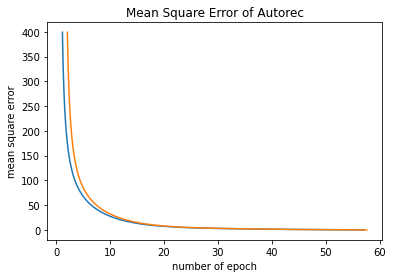

In [ ]:
import matplotlib.pyplot as plt
plt.plot(MSE_train,range(len(MSE_train)),label='Train')
plt.xlabel('number of epoch')
plt.ylabel('mean square error')
plt.plot(MSE_val,range(len(MSE_val)),label='Validation')
plt.title('Mean Square Error of Autorec')

#3)RNN:#

In [ ]:
tags['item id'].iloc[0]

37733

In [ ]:
tags=tags.set_index(['user id','item id'])

In [ ]:
rating=rating.set_index(['user id','item id'])

In [ ]:
tags.shape

(36613, 1)

In [ ]:
rating.shape

(1250207, 1)

In [ ]:
dataframe=tags.join(rating).dropna()
#df.set_index('key').join(other.set_index('key'))

In [ ]:
dataframe.columns

Index(['tag', 'rating'], dtype='object')

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import math

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import unicodedata
import string
import math

all_letters = string.ascii_letters+ string.digits + string.punctuation
n_letters = len(all_letters)

In [ ]:
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z]+", r" ", s)
    return s

In [ ]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))


Slusarski


In [ ]:
import numpy as np
category_lines={}
for i in range(dataframe.shape[0]):
  if dataframe['rating'].iloc[i] not in category_lines:
       category_lines[dataframe['rating'].iloc[i]]=[dataframe['tag'].iloc[i]]
  else:
       category_lines[dataframe['rating'].iloc[i]].append(dataframe['tag'].iloc[i])
for i in category_lines:
   category_lines[i]=np.unique(category_lines[i]).tolist()

In [ ]:
# Build the category_lines dictionary, a list of names per language
train_data = {}
validation_data = {}
all_categories = []


for category in category_lines:
    all_categories.append(category)
    lines = category_lines[category]
    random.shuffle(lines)
    train_data[category] = lines[0:int(math.floor(0.8*len(lines)))]
    validation_data[category] = lines[int(math.floor(0.8*len(lines)))+1:]

n_categories = len(all_categories)

In [ ]:
n_categories

10

In [ ]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

def sentenceToTensor(sentence):
    tensor = torch.zeros(len(sentence), 1, n_letters)
    for li, letter in enumerate(sentence):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor


#print(letterToTensor('J')[0])

#print(lineToTensor('Jones'))

print(sentenceToTensor('Joes Harr'))

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.

In [ ]:
class RNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_LSTM, self).__init__()

        self.hidden_size = hidden_size

        self.LSTM=nn.LSTMCell(input_size,hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, cell):
        hidden, cell = self.LSTM(input, (hidden,cell))
        combined = torch.cat((input, hidden), 1)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output,hidden,cell

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn_lstm = RNN_LSTM(n_letters, n_hidden, n_categories)

In [ ]:
input = sentenceToTensor('Annetta Harry')
hidden = torch.zeros(1, n_hidden)
cell=torch.zeros(1, n_hidden)
output,hidden,cell= rnn_lstm(input[0], hidden,cell)
print(output)

tensor([[-2.3446, -2.3187, -2.3390, -2.2734, -2.3322, -2.3016, -2.2266, -2.2985,
         -2.3081, -2.2889]], grad_fn=<LogSoftmaxBackward>)


In [ ]:
def train_LSTM(category_tensor, line_tensor):
    hidden = rnn_lstm.initHidden()
    cell= rnn_lstm.initHidden()
    # reset gradient
    rnn_lstm.zero_grad()

    for i in range(line_tensor.size()[0]):
        output,hidden,cell = rnn_lstm(line_tensor[i], hidden, cell)
    loss = criterion_lstm(output, category_tensor)

    # compute gradient by backpropagation
    loss.backward()

    # update parameters
    optimizer_lstm.step()

    return output, loss.item()

In [ ]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

(1.0, 6)


In [ ]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(train_data[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = sentenceToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = 0.5 / line = twistending
category = 0.5 / line = centralevent weddingpreparation
category = 5.0 / line = imaginaryworld characters story philosophical
category = 3.5 / line = bradleycooper
category = 5.0 / line = captainamerica
category = 3.5 / line = existentialism
category = 0.5 / line = dccomics
category = 1.5 / line = remakeoflettherightonein 
category = 3.0 / line = jacknicholson
category = 3.5 / line = alzheimer sdisease


In [ ]:
criterion = nn.NLLLoss()

In [ ]:
import time
import math
from torch.autograd import Variable

criterion_lstm = nn.NLLLoss()
rnn_lstm = RNN_LSTM(n_letters, n_hidden, n_categories)
optimizer_lstm = torch.optim.Adam(rnn_lstm.parameters())

n_iters = 80000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
train_loss_lstm = 0
all_train_losses_lstm = []
all_validation_losses_lstm = []
all_validation_losses2_lstm = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Just return an output given a line
def evaluate_lstm(line_tensor):
    hidden = rnn_lstm.initHidden()
    cell= rnn_lstm.initHidden()
    for i in range(line_tensor.size()[0]):
        output,hidden,cell = rnn_lstm(line_tensor[i], hidden,cell)
    return output

def eval_dataset_lstm(dataset):
    loss = 0
    n_instances = 0
    confusion = torch.zeros(n_categories, n_categories)
    for category in all_categories:
        category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
        n_instances += len(dataset[category])
        for line in dataset[category]:
            line_tensor = Variable(sentenceToTensor(line))
            output = evaluate_lstm(line_tensor)
            loss += criterion_lstm(output, category_tensor)
            guess, guess_i = categoryFromOutput(output)
            category_i = all_categories.index(category)
            confusion[category_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(n_categories):
        confusion[i] = confusion[i] / confusion[i].sum()

    return loss.item() / n_instances, confusion

print('\nIter \tTrain% \tTime \t\tTrain_loss_lstm \tExample')
start = time.time()
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train_LSTM(category_tensor, line_tensor)
    train_loss_lstm += loss

    # Print iter number, train loss average, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d \t%d%% \t(%s) \t%.4f \t\t%s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), train_loss_lstm / plot_every, line, guess, correct))

    # Add current train loss average to list of losses
    if iter % plot_every == 0:
        all_train_losses_lstm.append(train_loss_lstm / plot_every)
        train_loss_lstm = 0

    # Compute loss based on validation data
    if iter % plot_every == 0:
        average_validation_loss_lstm, _ = eval_dataset_lstm(validation_data)

        # save model with best validation loss
        if len(all_validation_losses_lstm) == 0 or average_validation_loss_lstm < min(all_validation_losses_lstm):
            torch.save(rnn_lstm, 'char_rnn_lstm_classification_model.pt')
        all_validation_losses_lstm.append(average_validation_loss_lstm)



Iter 	Train% 	Time 		Train_loss_lstm 	Example
5000 	6% 	(1m 0s) 	2.2943 		hallucinatory / 3.0 ✗ (1.0)
10000 	12% 	(2m 7s) 	2.2908 		space / 4.5 ✗ (2.5)
15000 	18% 	(3m 14s) 	2.2729 		police / 0.5 ✗ (2.5)
20000 	25% 	(4m 22s) 	2.2845 		actionpacked / 3.0 ✓
25000 	31% 	(5m 29s) 	2.2578 		socjopat / 1.0 ✓
30000 	37% 	(6m 36s) 	2.2737 		notfaithfultothebook / 1.5 ✗ (3.5)
35000 	43% 	(7m 42s) 	2.2491 		manvs nature / 1.5 ✗ (4.5)
40000 	50% 	(8m 50s) 	2.2442 		identitypolitics / 1.5 ✗ (4.0)
45000 	56% 	(9m 58s) 	2.2158 		oscar besteffects visualeffects  / 0.5 ✓
50000 	62% 	(11m 7s) 	2.2217 		hijacking / 0.5 ✗ (5.0)
55000 	68% 	(12m 16s) 	2.1782 		sidneylumet / 1.0 ✗ (4.5)
60000 	75% 	(13m 25s) 	2.1721 		taikawaititi / 2.5 ✗ (5.0)
65000 	81% 	(14m 33s) 	2.1557 		truestory / 1.5 ✗ (0.5)
70000 	87% 	(15m 41s) 	2.1194 		sexualharassment / 2.0 ✗ (3.0)
75000 	93% 	(16m 49s) 	2.0646 		endingkindaruinedit / 4.0 ✗ (2.0)
80000 	100% 	(17m 56s) 	2.1026 		slackers / 0.5 ✗ (5.0)


In [ ]:
def predict(input_line, n_predictions=1):
    #print('\n> %s' % input_line)
    with torch.no_grad():
        output = torch.exp(evaluate_lstm(sentenceToTensor(input_line)))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            #print(all_categories[category_index])
            predictions.append(all_categories[category_index])
    return(output, predictions)
predict('father')

(tensor([[0.0886, 0.1009, 0.0519, 0.1706, 0.1320, 0.0672, 0.1087, 0.1105, 0.0438,
          0.1257]]), [2.5])

In [ ]:
predict('')

(tensor([[0.0766, 0.0735, 0.1013, 0.0542, 0.1355, 0.0893, 0.3054, 0.0684, 0.0292,
          0.0665]]), [1.0])

In [ ]:
#train accuracy:
MSE=0
count=0
for i in train_data:
  for j in train_data[i]:
        output,pred=predict(j,n_predictions=1)
        MSE+=(float(pred[0])-float(i))**2
       # print(MSE)
        count+=1
print(MSE/count)


4.094855375500958


In [ ]:
#validation accuracy:
MSE=0
count=0
for i in validation_data:
  for j in validation_data[i]:
        output,pred=predict(j,n_predictions=1)
        MSE+=(float(pred[0])-float(i))**2
       # print(MSE)
        count+=1
print(MSE/count)


4.4090432960893855


#Use word to vec method:#

In [ ]:
import keras
import numpy as np
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint


In [ ]:
max_features = 440 #This is highest frequency threshold for all indices.
maxlen = 3  # cut texts after this number of words (among top max_features most common words)
batch_size = 32
num_classes = 10

In [ ]:
import re  # For preprocessing
from time import time  # To time our operations
from collections import defaultdict  # For word frequency
import spacy  # For preprocessing

In [ ]:
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z]+", r" ", s)
    s=s.strip()
    return s

In [ ]:
dataframe.tag[:100]

user id  item id
42       37733      disappointing
         37733          overrated
         37733             stupid
332      236             Meg Ryan
         3408       Julia Roberts
                        ...      
526      6953             Tragedy
         6975          dark humor
         6975          disturbing
         6975             torture
         8507        banned movie
Name: tag, Length: 100, dtype: object

In [ ]:
dataframe.shape

(33454, 2)

In [ ]:
text_combine=dataframe['tag']
len(text_combine)

33454

In [ ]:
text_combine

user id  item id
42       37733      disappointing
         37733          overrated
         37733             stupid
332      236             Meg Ryan
         3408       Julia Roberts
                        ...      
282989   2571        martial arts
         2571               ulhas
         6365             awesome
283117   4011       Jason Statham
         4011        twist ending
Name: tag, Length: 33454, dtype: object

In [ ]:
text_combine

user id  item id
42       37733      disappointing
         37733          overrated
         37733             stupid
332      236             Meg Ryan
         3408       Julia Roberts
                        ...      
282989   2571        martial arts
         2571               ulhas
         6365             awesome
283117   4011       Jason Statham
         4011        twist ending
Name: tag, Length: 33454, dtype: object

In [ ]:
from gensim.models.phrases import Phrases, Phraser

In [ ]:
#As Phrases() takes a list of list of words as input:
#Creates the relevant phrases from the list of sentences:
sent = [row.split() for row in text_combine]
phrases = Phrases(sent, progress_per=10000)
#The goal of Phraser() is to cut down memory consumption of Phrases(), by discarding model state not strictly needed for the bigram detection task:
sentences = phrases[sent]


/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


7427

In [ ]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['comedy',
 'sci-fi',
 'dark',
 'action',
 'atmospheric',
 'surreal',
 'based_on',
 'funny',
 'classic',
 'visually_appealing']

In [ ]:
from gensim.models import Word2Vec

In [ ]:
import multiprocessing
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
cores

2

In [ ]:
w2v_model = Word2Vec(min_count=0,
                     window=2,
                     size=300,
                     sample=6e-5,
                     alpha=0.03,
                     min_alpha=0.0007,
                     negative=20,
                     workers=cores-1)

In [ ]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


Time to build vocab: 0.03 mins


In [ ]:
w2v_model.init_sims(replace=True)

In [ ]:
#most similiar words to "us"
w2v_model.wv.most_similar(positive=["male"])

[('surreal', 0.2451900690793991),
 ('Abigail', 0.2125636339187622),
 ('Eddie', 0.2085777074098587),
 ('tense', 0.20810966193675995),
 ('this', 0.20528408885002136),
 ('Lilly', 0.2009146511554718),
 ('Wulff', 0.19531753659248352),
 ('hanging', 0.19269561767578125),
 ('best', 0.19218936562538147),
 ('Spacey', 0.1895468682050705)]

In [ ]:
model_name = "product_content_clean"
w2v_model.save(model_name)

In [ ]:
model = Word2Vec.load("product_content_clean")

In [ ]:
word_vectors = model.wv.syn0 #array essentially holds raw word-vectors.these vectors are a 'projection layer' that can convert a one-hot encoding of a word into a dense embedding-vector of the right dimensionality.
word_vectors

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


array([[-0.03292004,  0.0008825 ,  0.04877856, ..., -0.03010911,
        -0.03559132,  0.07979657],
       [-0.00292705,  0.08412421,  0.06638248, ..., -0.02763497,
        -0.04794508, -0.09617441],
       [ 0.03382205,  0.07162233, -0.00565149, ..., -0.08166121,
         0.07653634, -0.07900032],
       ...,
       [ 0.00538273, -0.0544017 ,  0.02036488, ...,  0.05994604,
        -0.03334845, -0.01385388],
       [-0.01945043,  0.02121533, -0.04944266, ...,  0.02177351,
         0.08666735, -0.0569833 ],
       [-0.03831702, -0.09806774, -0.08820985, ...,  0.06559112,
         0.08154435,  0.0141946 ]], dtype=float32)

In [ ]:
#word2index is dictionary of all words as key and value is frequency in corpus:
word2index = {token: token_index for token_index, token in enumerate(model.wv.index2word)}
"US" in word2index

True

In [ ]:
len(word2index)

7427

In [ ]:
print(model.wv.index2word[:10])
word="male"
print(model.wv.vocab.get(word).index)


['comedy', 'sci-fi', 'dark', 'action', 'atmospheric', 'surreal', 'based_on', 'funny', 'classic', 'visually_appealing']
865


In [ ]:
sentences_index=[]
for news in sentences:
    lst=[]
    for word in news:
      if word in word2index:#if the word is in corpus
        if word2index[word]+1<max_features-1:#exclude extremely rare words
           lst.append(word2index[word]+1)
    sentences_index.append(lst)


/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
len(sentences_index)

33454

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
label_list=dataframe['rating'].tolist()
le.fit(label_list)
transfomed_label =le.transform(label_list)
print(transfomed_label)
print(transfomed_label.shape)

[2 2 2 ... 8 9 9]
(33454,)


In [ ]:
len(sentences_index)

33454

In [ ]:
x_train_text=sentences_index[:21508]
x_test_text=sentences_index[21508:]
x_val_text=x_train_text[-4301:]
x_train_text=x_train_text[:-4301]
y_train_text=dataframe['rating'].tolist()[:21508]
y_test_text=dataframe['rating'].tolist()[21508:]
y_val_text=y_train_text[-4301:]
y_train_text=y_train_text[:-4301]
print(len(x_train_text))
print(len(y_train_text))
print(len(x_test_text))
print(len(y_test_text))
print(len(x_val_text))
print(len(y_val_text))

17207
17207
11946
11946
4301
4301


In [ ]:
# create a callback that will save the best model while training
checkpoint = ModelCheckpoint('best_model_text.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

In [ ]:
print('Pad sequences (samples x time)')
x_train_text = sequence.pad_sequences(x_train_text, maxlen=maxlen)
x_val_text = sequence.pad_sequences(x_val_text, maxlen=maxlen)
print('x_train shape:', x_train_text.shape)
print('x_test shape:', x_val_text.shape)

Pad sequences (samples x time)
x_train shape: (17207, 3)
x_test shape: (4301, 3)


In [ ]:
print('Pad sequences (samples x time)')
x_test_text = sequence.pad_sequences(x_test_text, maxlen=maxlen)

Pad sequences (samples x time)


In [ ]:
model = Sequential()

#######################
#  Embedding layer[4] #
#######################
# - the model will take as input an integer matrix of size (batch_size, input_length).
# - the largest integer (i.e. word index) in the input should be no larger than (max_features-1)
#   (vocabulary size).
# - now model.output_shape == (None, input_length, 128), where None is the batch dimension.
model.add(Embedding(max_features, 128, input_length=maxlen))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='relu'))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 3, 128)            56320     
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 188,033
Trainable params: 188,033
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# try using different optimizers and different optimizer configs
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer='adam',
metrics=['mse'])

In [ ]:
print('Train...')
history=model.fit(x_train_text, y_train_text,
          batch_size=batch_size,
          epochs=50,callbacks=[checkpoint],
validation_data=(x_val_text, y_val_text))

Train...
Train on 17207 samples, validate on 4301 samples
Epoch 1/50
17088/17207 [============================>.] - ETA: 0s - loss: 1.5292 - mean_squared_error: 1.5292

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: val_loss improved from inf to 0.59216, saving model to best_model_text.h5
17207/17207 [==============================] - 7s 398us/sample - loss: 1.5278 - mean_squared_error: 1.5278 - val_loss: 0.5922 - val_mean_squared_error: 0.5922
Epoch 2/50
17024/17207 [============================>.] - ETA: 0s - loss: 0.9564 - mean_squared_error: 0.9564
Epoch 00002: val_loss did not improve from 0.59216
17207/17207 [==============================] - 4s 247us/sample - loss: 0.9577 - mean_squared_error: 0.9577 - val_loss: 0.5933 - val_mean_squared_error: 0.5933
Epoch 3/50
17184/17207 [============================>.] - ETA: 0s - loss: 0.9382 - mean_squared_error: 0.9382
Epoch 00003: val_loss did not improve from 0.59216
17207/17207 [==============================] - 4s 247us/sample - loss: 0.9384 - mean_squared_error: 0.9384 - val_loss: 0.5924 - val_mean_squared_error: 0.5924
Epoch 4/50
17024/17207 [============================>.] - ETA: 0s - loss: 0.9303 - mean_squared_error: 0.9303
Epo

In [ ]:
mse_train_lstm=history.history['mean_squared_error']

In [ ]:
mse_val_lstm=history.history['val_mean_squared_error']

Text(0.5, 1.0, 'Mean Square Error of LSTM')

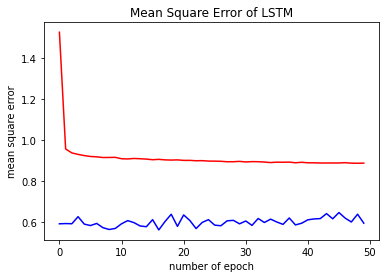

In [ ]:
plt.plot(range(len(mse_train_lstm)),mse_train_lstm,'r')
plt.xlabel('number of epoch')
plt.ylabel('mean square error')
plt.plot(range(len(mse_val_lstm)),mse_val_lstm,'b')
plt.title('Mean Square Error of LSTM')

In [ ]:
x_test_text[:2]

array([[ 0,  0, 97],
       [ 0, 22, 69]], dtype=int32)

test error:

In [ ]:
from sklearn.metrics import mean_squared_error
y_prd=model.predict(x_test_text)
mean_squared_error(y_test_text, y_prd)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


0.8262903425320216

In [ ]:
y_prd[:20]

array([[3.835919 ],
       [4.0168676],
       [4.483152 ],
       [2.7424881],
       [4.305943 ],
       [4.5455785],
       [3.9788396],
       [3.743502 ],
       [4.3266573],
       [3.743502 ],
       [3.743502 ],
       [4.4087996],
       [4.5416837],
       [4.3866453],
       [4.196027 ],
       [3.9767897],
       [4.408564 ],
       [4.2162642],
       [3.7134106],
       [3.9375434]], dtype=float32)

In [ ]:
y_test_text[20:]

[4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.5,
 3.5,
 3.5,
 3.5,
 3.5,
 3.5,
 3.5,
 3.5,
 3.0,
 3.0,
 3.5,
 3.5,
 3.5,
 3.5,
 3.5,
 3.5,
 3.5,
 3.5,
 3.5,
 3.5,
 3.5,
 3.5,
 3.5,
 3.5,
 3.5,
 3.5,
 3.5,
 3.5,
 3.5,
 3.5,
 3.5,
 3.5,
 3.5,
 3.5,
 4.5,
 4.5,
 4.5,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.5,
 4.5,
 4.5,
 4.5,
 4.5,
 4.5,
 4.5,
 4.5,
 4.5,
 4.5,
 4.5,
 4.5,
 3.0,
 3.0,
 3.5,
 4.0,
 4.0,
 4.0,
 4.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.5,
 4.5,
 3.5,
 3.5,
 3.5,
 3.5,
 3.5,
 3.5,
 3.5,
 3.5,
 3.5,
 3.5,
 3.5,
 3.5,
 3.5,
 3.5,
 3.5,
 3.5,
 3.5,
 3.5,
 3.5,
 3.5,
 3.5,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0

In [ ]:
dataframe['tag'].tolist()[21508:][:20]

['Disney',
 'good soundtrack',
 'Oscar (Best Music - Original Song)',
 'predictable',
 'clever',
 'complicated',
 'disturbing',
 'fighting',
 'great acting',
 'helena bonham carter',
 'macho',
 'mindfuck',
 'philosophy',
 'powerful ending',
 'psychology',
 'stylized',
 'thought-provoking',
 'twist ending',
 'violence',
 'Al Pacino']

validation errro

In [ ]:
y_prd=model.predict(x_val_text)
mean_squared_error(y_val_text, y_prd)

0.6429364089071816

In [ ]:
y_prd=model.predict(x_train_text)
mean_squared_error(y_train_text, y_prd)

0.7203894201638275